# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [80]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [81]:
# Import essential libraries
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense,RandomFlip,RandomZoom,RandomRotation,Flatten
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import zipfile
import cv2
from PIL import Image
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Rescaling

Load the dataset.

In [82]:
# Load and unzip the dataset
#with zipfile.ZipFile('data.zip', 'r') as zip_ref:
#    zip_ref.extractall('data')  # Extracts to folder `data/`
# Step 2: Load with ImageDataGenerator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [83]:
# Create a function to load the raw images

data_dir = r'C:\Users\DELL\OneDrive\AI-ML\ANN\assignment\data\data'
img_height = 128
img_width = 128
batch_size = 32

ds  = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=None,
    subset=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 7625 files belonging to 7 classes.


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [84]:
# Get the images and their labels
class_names = ds.class_names
print("Class names:", class_names)



Class names: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

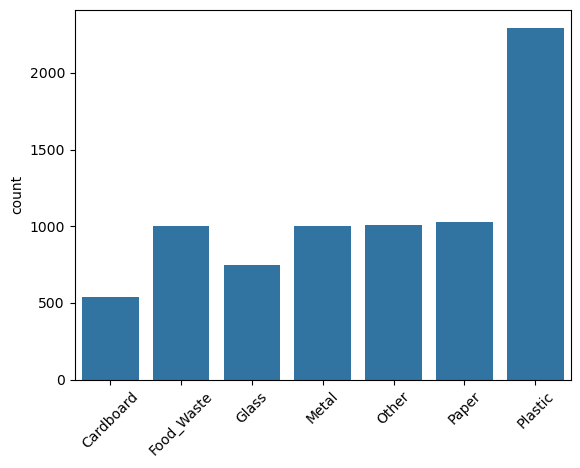

Cardboard      7.081967
Food_Waste    13.114754
Glass          9.836066
Metal         13.114754
Other         13.245902
Paper         13.508197
Plastic       30.098361
Name: count, dtype: float64


In [85]:
# Visualise Data Distribution
dataset_unbatched = tuple(ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = ds.class_names

sns.barplot(count)
plt.xticks(rotation=45)
plt.show()
print((count/count.sum())*100)

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

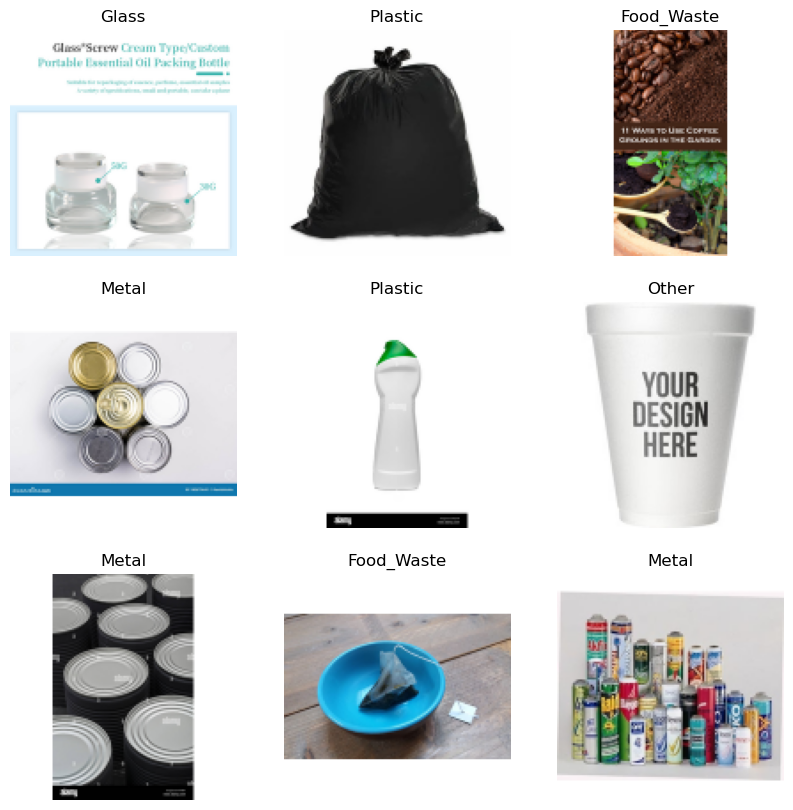

In [86]:
# Visualise Sample Images (across different labels)

#visualizing few images
plt.figure(figsize=(10, 10))
for images, labels in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [87]:
def get_min_max_image_sizes_recursive(main_directory_path):
    """
    Finds the minimum and maximum dimensions (width, height) of images
    within the main directory and all its subdirectories.

    Args:
        main_directory_path (str): The path to the main directory.

    Returns:
        tuple: A tuple containing two tuples:
               (min_size, max_size)
               where min_size = (min_width, min_height)
               and max_size = (max_width, max_height)
               Returns (None, None) if no images are found or an error occurs.
    """
    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0
    found_images = False

    if not os.path.isdir(main_directory_path):
        print(f"Error: Main directory not found at '{main_directory_path}'")
        return None, None

    # os.walk generates the file names in a directory tree by walking the tree top-down
    for root, dirs, files in os.walk(main_directory_path):
        for filename in files:
            file_path = os.path.join(root, filename)

            # Check if it's a file and a common image extension
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                try:
                    with Image.open(file_path) as img:
                        width, height = img.size
                        found_images = True

                        # Update min dimensions
                        min_width = min(min_width, width)
                        min_height = min(min_height, height)

                        # Update max dimensions
                        max_width = max(max_width, width)
                        max_height = max(max_height, height)

                except IOError:
                    print(f"Warning: Could not open image file: {file_path}. Skipping.")
                except Exception as e:
                    print(f"An unexpected error occurred with file {file_path}: {e}. Skipping.")

    if not found_images:
        print(f"No valid image files found in '{main_directory_path}' or its subdirectories.")
        return None, None
    else:
        return (min_width, min_height), (max_width, max_height)

directory_path = r'C:\Users\DELL\OneDrive\AI-ML\ANN\assignment\data\data'  

min_size, max_size = get_min_max_image_sizes_recursive(directory_path)

if min_size and max_size:
    print(f"\nMinimum image size (width, height): {min_size}")
    print(f"Maximum image size (width, height): {max_size}")



Minimum image size (width, height): (256, 256)
Maximum image size (width, height): (256, 256)


In [88]:
# Resize the image dimensions

#since max and min size are same, we need not do resizing of image. To keep the image size smaller we can make it 100x100


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [89]:
# Encode the labels suitably
num_classes = 7

# Use to_categorical to one-hot encode the labels
one_hot_labels = to_categorical(labels, num_classes=num_classes)

# one_hot_labels will now be a NumPy array where each row represents
# the one-hot encoded vector for a label.
print(one_hot_labels)


tf.Tensor(
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]], shape=(32, 7), dtype=float32)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [90]:
# Assign specified parts of the dataset to train and validation sets
train_ds,val_ds  = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='both',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 7625 files belonging to 7 classes.
Using 6100 files for training.
Using 1525 files for validation.


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [91]:
# Build and compile the model
model = Sequential()
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# summary
model.summary()

c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_53 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 7)              │         1,799 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_54 (Activation)      │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,649,735 (128.36 MB)

 Trainable params: 33,649,735 (128.36 MB)

 Non-trainable params: 0 (0.00 B)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [92]:
# Training
# compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train 
history = model.fit(train_ds, epochs=8, validation_data=val_ds)


Epoch 1/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 676s 4s/step - accuracy: 0.2864 - loss: 2.8589 - val_accuracy: 0.3613 - val_loss: 1.7184
Epoch 2/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.3883 - loss: 1.6145 - val_accuracy: 0.4282 - val_loss: 1.5334
Epoch 3/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.4661 - loss: 1.4508 - val_accuracy: 0.4610 - val_loss: 1.4804
Epoch 4/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.5288 - loss: 1.2803 - val_accuracy: 0.5134 - val_loss: 1.3873
Epoch 5/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.6018 - loss: 1.0938 - val_accuracy: 0.5384 - val_loss: 1.3406
Epoch 6/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.6749 - loss: 0.8676 - val_accuracy: 0.5449 - val_loss: 1.4434
Epoch 7/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.7459 - loss: 0.6998 - val_accuracy: 0.5784 - val_loss: 1.4451
Epoch 8/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.8060 - loss: 0.5669 - val_accuracy: 0.

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 286ms/step - accuracy: 0.5817 - loss: 1.6285
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


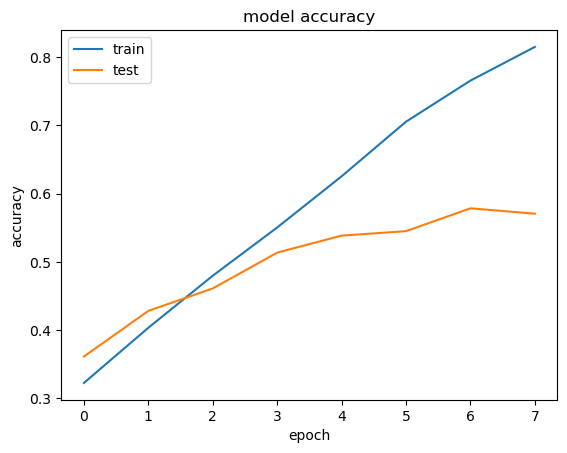

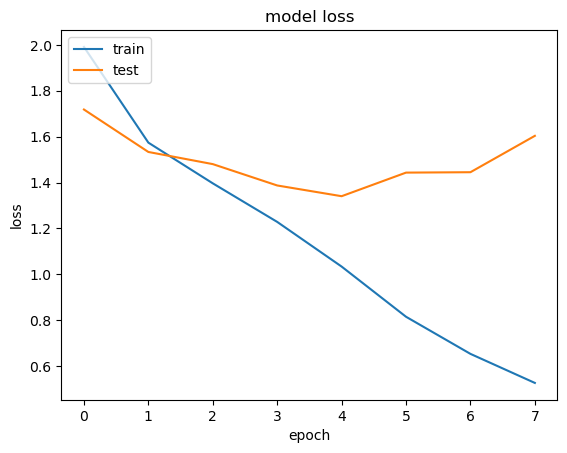

In [94]:
# Evaluate on the test set; display suitable metrics
model.evaluate(val_ds)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [95]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [96]:
# Create a function to augment the images




In [97]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [98]:
# Train the model using augmented images
# Build and compile the model
model2 = Sequential()
model2.add(RandomFlip("horizontal"))
model2.add(RandomRotation(0.1))        # Rotate 10%
model2.add(RandomZoom(0.1))            # Zoom up to 10%

model2.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model2.add(Conv2D(32, (3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(32,(3,3),padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.3))

model2.add(Conv2D(64,(3,3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.3))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

# summary
model2.summary()

# compile the model
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(train_ds, epochs=5, validation_data=val_ds)
model2.evaluate(val_ds)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_5 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_5 (RandomZoom)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_55 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_56 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_57 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_58 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_59 (Activation)      │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.2850 - loss: 2.4323 - val_accuracy: 0.3823 - val_loss: 1.6730
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.3858 - loss: 1.5844 - val_accuracy: 0.3843 - val_loss: 1.5933
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.4240 - loss: 1.5191 - val_accuracy: 0.4098 - val_loss: 1.5727
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.4461 - loss: 1.4831 - val_accuracy: 0.4098 - val_loss: 1.5338
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.4463 - loss: 1.4495 - val_accuracy: 0.4282 - val_loss: 1.4854
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.4264 - loss: 1.5063


[1.4853904247283936, 0.4281967282295227]

In [99]:
# Trying with transfer learning VGG16
from keras.applications.vgg16 import VGG16
from tensorflow.keras import layers

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, 3))
conv_base.summary()

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_width, img_height),
    tf.keras.layers.Rescaling(0.1 / 256)
])

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
model = Sequential()
resize_and_rescale
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

model.summary()
# disable convolustion layers for training
conv_base.trainable = False 

# compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train 
model.fit(train_ds, epochs=8, validation_data=val_ds)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,895 (64.14 MB)

 Trainable params: 16,813,895 (64.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 616s 3s/step - accuracy: 0.4233 - loss: 10.8621 - val_accuracy: 0.5757 - val_loss: 1.2583
Epoch 2/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 556s 3s/step - accuracy: 0.5861 - loss: 1.2827 - val_accuracy: 0.6184 - val_loss: 1.1067
Epoch 3/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 1426s 7s/step - accuracy: 0.6289 - loss: 1.0854 - val_accuracy: 0.6374 - val_loss: 1.0394
Epoch 4/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 24936s 131s/step - accuracy: 0.6536 - loss: 1.0458 - val_accuracy: 0.6774 - val_loss: 1.0303
Epoch 5/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - accuracy: 0.6758 - loss: 1.0004 - val_accuracy: 0.6761 - val_loss: 0.9689
Epoch 6/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 591s 3s/step - accuracy: 0.6905 - loss: 0.8392 - val_accuracy: 0.7043 - val_loss: 0.9391
Epoch 7/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 574s 3s/step - accuracy: 0.7049 - loss: 0.8464 - val_accuracy: 0.6925 - val_loss: 0.9496
Epoch 8/8
191/191 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.7148 - loss: 0.7623 - val_accura

In [101]:
# Evaluate on the test set; display suitable metrics
model.evaluate(val_ds)

48/48 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7034 - loss: 0.9852


[0.9545543789863586, 0.7049180269241333]

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

1. Images are stored in 7 sub folders 
    'Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic
2. 7 folders lead to 7 classes - Cardboard, Food_Waste, Glass, Metal, Other, Paper,Plastic
3. Classes are imbalanced - highest being Plastic </br >
Cardboard      7 %</br >
Food_Waste     13 %</br >
Glass          10 %</br >
Metal          13%</br >
Other          13%</br >
Paper          13%</br >
Plastic        13%</br >
4. Maximum and minimum size of images are 256x256 
5. Model is built with 3 2D convolution layer, 2 Max pooling layer, 1 dense layer and softmax layer initially with no drop out
    Model trainng accuracy was 0.93 , testing accuracy was 0.6. This is a clear overfitting situation
    Model was trained with epochs - 8 . After adding drop out the training accuracy dropped to 0.8 , test accuracy remained at 0.57.
6. Model was finetuned with drop out 30% in 3 layers , accuracy of the training data was 0.8 and validation was 0.6. Still there is high degree of overfitting.
7. Using transfer learning with VGG6 , result achieved was better both validationa and test accuracy was about 0.7.
8. Overaal Epoch required is 8 -10 . 5 is not sufficient
9. Overall transfer learning from VGG16 was much stable and better in terms of model performance.